# 3D Gaussian Splatting for Real-Time Radiance Field Rendering (SIGGRAPH 2023)

arXiv - https://arxiv.org/abs/2308.04079

## 0. What is 3D Gaussian Splatting?

In page 4 of the paper,

> *We Choose 3D Gaussians, which are differentiable and can be easily projected to 2D Splats allowing fast alpha-blending or rendering.*

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/overview.JPG" alt="Overview of 3D Gaussian Splatting">
</div>

## 1. Preprocess the Dataset

### 1.1 Download the NeRF-synthetic Dataset

> The paper uses 3 datasets, NeRF-synthetic dataset, Mip-NeRF 360 dataset, and Tanks&Templates dataset.

We will start with NeRF-synthetic dataset that are easy to access.

In [ ]:
from pathlib import Path
import gdown

# Setup dataset folder
dataset_path = Path("datasets/")

# Check if the dataset folder exists, and if not, download the dataset.
if dataset_path.is_dir():
  print(f"[INFO] {dataset_path} already exists.")
else:
  print(f"[INFO] Cannot find {dataset_path}, creating the directory...")
  dataset_path.mkdir(parents=True, exist_ok=True)

[INFO] Cannot find datasets, creating the directory...


In [ ]:
!gdown "https://drive.google.com/uc?id=1OsiBs2udl32-1CqTXCitmov4NQCYdA9g" -O "./datasets/nerf_synthetic.zip"

Downloading...
From (original): https://drive.google.com/uc?id=1OsiBs2udl32-1CqTXCitmov4NQCYdA9g
From (redirected): https://drive.google.com/uc?id=1OsiBs2udl32-1CqTXCitmov4NQCYdA9g&confirm=t&uuid=fcc54b73-7f40-4a5e-9d8d-bd3865d1bdc6
To: /content/datasets/nerf_synthetic.zip
100% 1.27G/1.27G [00:17<00:00, 73.0MB/s]


In [ ]:
import zipfile

# Unzip NeRF_Synthetic dataset
with zipfile.ZipFile(dataset_path / "nerf_synthetic.zip", "r") as zip_ref:
  print("[INFO] Unzipping nerf_synthetic dataset...")
  zip_ref.extractall(dataset_path)

# Delete existing compressed dataset file
!rm "./datasets/nerf_synthetic.zip"

[INFO] Unzipping nerf_synthetic dataset...


### 1.2 Explore the NeRF-synthetic dataset


Stats:
+ 8 Scenes -  ***(chair, drums, ficus, hotdog, lego, materials, mic, ship)***
+ 100 Training images
+ 100 Validation images
+ 200 Test images
+ Images are 800x800

Structure:
  * SCENE_NAME
    * train
      * r_num.png
    * val
      * r_num.png
    * test
      * r_num.png
      * r_num_depth_0000.png
      * r_num_normal_0000.png
    * transforms_train.json
    * transforms_val.json
    * transforms_test.json

Transform json details:
  * camera_angle_x: The FOV in x dimension
  * frames: List of dictionaries that contain the camera transform matrices for each image.


Random image path: datasets/nerf_synthetic/ship/test/r_40.png
Image Height * Width : 800 * 800


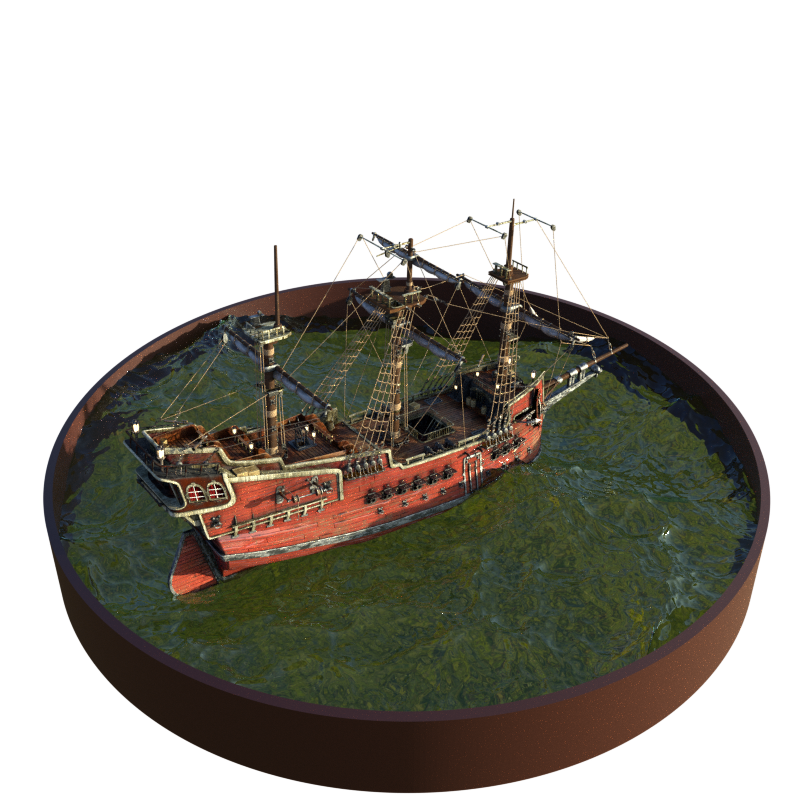

In [ ]:
import random
from PIL import Image

# Get All Image Paths
nerf_synthetic_path = dataset_path / "nerf_synthetic"
image_path_list = list(nerf_synthetic_path.glob("*/*/*.png"))

# Get Random Image Path
random_image_path = random.choice(image_path_list)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image Height * Width : {img.height} * {img.width}")
img

### ***(Optional)*** 1.3 Make SfM (Structure-from-Motion) points from NeRF-synthetic dataset



**Note:** The below process takes a long time, so you can skip to **1.4 Download SfM points from HuggingFace**

In [ ]:
!pip install pycolmap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 20.0 MB/s eta 0:00:00


```python
from pathlib import Path
import pycolmap
from pycolmap import logging
import shutil

def make_SfM_points(image_path: Path, category: str):
  """
  Args:
    image_path : pathlib.Path
    category : str - (e.g, chair, drums, ficus, hotdog, lego, materials, mic, ship)
  """
  output_path = Path("COLMAP/")
  category_path = output_path / category

  category_path.mkdir(parents=True, exist_ok=True)
  logging.set_log_destination(logging.INFO, output_path / "logs")

  database_path = category_path / "database.db"
  sfm_path = category_path / "sfm"

  print(f"[INFO] Processing category: {category}")
  if database_path.exists():
    database_path.unlink()

  pycolmap.extract_features(database_path, image_path)
  pycolmap.match_exhaustive(database_path)

  num_images = pycolmap.Database(database_path).num_images
  print(f"[INFO] Found {num_images} images in {category} dataset.")

  if sfm_path.exists():
    shutil.rmtree(sfm_path)
  sfm_path.mkdir(exist_ok=True)

  records = pycolmap.incremental_mapping(database_path, image_path, sfm_path)

  for idx, record in records.items():
    logging.info(f"#{idx} {record.summary}")

  print(f"[INFO] SfM completed for {category}.")
```

```python
categories = ["chair", "drums", "ficus", "hotdog", "lego", "materials", "mic", "ship"]

for category in categories:
  image_path = nerf_synthetic_path / category / "train"
  make_SfM_points(image_path, category)
```

### 1.4 Download SfM points from HuggingFace

- The dataset created in process 1.3 was uploaded to huggingface. - https://huggingface.co/datasets/pleasure97/NeRF_synthetic_SfM_Points

- Follow the below process and unzip the compressed file to a specified path.

In [ ]:
!wget -q https://huggingface.co/datasets/pleasure97/NeRF_synthetic_SfM_Points/resolve/main/NeRF_synthetic_SfM_points.zip
!unzip -q NeRF_synthetic_SfM_points.zip -d COLMAP/
!rm -rf NeRF_synthetic_SfM_points.zip


### 1.5 Visualize SfM points from NeRF-synthetic dataset

In [ ]:
!pip install -q open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.1 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
import pycolmap
import numpy as np
import open3d as o3d
import plotly.graph_objects as go

def create_SfM_points(sfm_path: Path):
  category = sfm_path.parent.stem
  reconstruction = pycolmap.Reconstruction(sfm_path)
  # Collect 3D points
  points = []
  colors = []

  for point3D in reconstruction.points3D.values():
    points.append(point3D.xyz)
    colors.append(point3D.color / 255.)

  points = np.array(points)
  colors = np.array(colors)

  print(f"[INFO] {category} points shape : {points.shape} | colors shape : {colors.shape}")

  return points, colors, category

def visualize_SfM_points(points, colors, category):
  """ Visualize the SfM points using Open3D.

  Args:
    points:
    colors:
    category:
  """
  # Create open3d point cloud
  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(points)
  pcd.colors = o3d.utility.Vector3dVector(colors)

  # Visualize the point cloud
  print(f"[INFO] Visualizing {category} {len(points)} points...")

  fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0], y=points[:,1], z=points[:,2],
            mode='markers',
            marker=dict(size=1, color=colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
  )
  fig.show()

In [ ]:
import random
categories = ["chair", "drums", "ficus", "hotdog", "lego", "materials", "mic", "ship"]
use_random = False
if use_random:
  selected_category = random.choice(categories)
  sfm_path = Path("COLMAP/") / selected_category / Path("sfm/0")
else:
  sfm_path = Path("COLMAP/hotdog/sfm/0")
points, colors, category = create_SfM_points(sfm_path)
visualize_SfM_points(points, colors, category)

[INFO] sfm points shape : (8261, 3) | colors shape : (8261, 3)
[INFO] Visualizing sfm 8261 points...


You can visualize point clouds like this:

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/SfM Points.png" alt="SfM Points">
</div>

## 2. Initialization




### 2.1 Create a set of 3D Gaussians

In page 4 of the paper,

> From these points we create a set of 3D Gaussians defined by a position (mean), covariance matrix and opacity $\alpha$

> Our Gaussians are defined by a full 3D covariance matrix $\Sigma$ defined in world space centered at point (mean) $\mu$

$$ G(x)=e^{-\frac{1}{2}(x)^T \Sigma^{-1}(x)}$$



In [ ]:
from pathlib import Path
import numpy as np
from scipy.stats import multivariate_normal
from typing import Dict
import plotly.graph_objects as go


def create_3D_Gaussians(points, colors, grid_size:int=100) -> Dict[str, np.array]:
  """ Create a set of 3D Gausssians.

  Args:
    sfm_path: Path to the SfM folder containing the COLMAP outputs.
  """

  points, colors, _ = create_SfM_points(sfm_path)

  # Calculate the mean
  mu = np.mean(points, axis=0)

  # Calculate the covariance matrix
  covariance_matrix = np.cov(points, rowvar=False)

  # Define the grid range
  x_range = np.linspace(points[:, 0].min(), points[:, 0].max(), grid_size)
  y_range = np.linspace(points[:, 1].min(), points[:, 1].max(), grid_size)
  z_range = np.linspace(points[:, 2].min(), points[:, 2].max(), grid_size)

  # Create a 3D grid
  x, y, z = np.meshgrid(x_range, y_range, z_range)
  grid_points = np.stack([x.ravel(), y.ravel(), z.ravel()], axis=1)

  # Create a multivariate Gaussian distribution
  gaussian = multivariate_normal(mean=mu, cov=covariance_matrix)

  # Reshape PDF values to match the grid
  pdf_values = gaussian.pdf(grid_points).reshape(x.shape)

  return  {
      "pdf_values": pdf_values,
      "x_range": x_range,
      "y_range": y_range,
      "z_range": z_range
  }

def visualize_3D_Gaussians(data: Dict[str, np.array]):

  pdf_values = data["pdf_values"]
  x_range = data["x_range"]
  y_range = data["y_range"]
  z_range = data["z_range"]

  # Generate Plotly Volume plot
  fig = go.Figure(data=go.Volume(
      x=np.repeat(x_range, len(y_range) * len(z_range)),
      y=np.tile(np.repeat(y_range, len(z_range)), len(x_range)),
      z=np.tile(z_range, len(x_range) * len(y_range)),
      value=pdf_values.ravel(),
      isomin=pdf_values.min(),
      isomax=pdf_values.max(),
      opacity=0.1,
      surface_count=10,
      colorscale="Viridis"
  ))

  # Setup plot
  fig.update_layout(
      scene=dict(
          xaxis_title="X",
          yaxis_title="Y",
          zaxis_title="Z",
          aspectmode="cube"
      ),
      title="3D Gaussian Visualization"
  )

  fig.show()

In [ ]:
gaussian_data = create_3D_Gaussians(points, colors)
# visualize_3D_Gaussians(gaussian_data)

[INFO] sfm points shape : (8261, 3) | colors shape : (8261, 3)


You can visualize the 3D Gaussian like this:

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/3D Gaussian.png" alt="3D Gaussian">
</div>

## 3. Projection




### 3.1 Operation Flow of Projection

In page 4 of the paper,
* $W$ - Viewing transform matrix
* $J$ - Jacobian of the affine approximation of the projective transform
* $\Sigma^{\prime}$ - Covariance matrix in view space

$$ \Sigma^{\prime}=J W \Sigma W^T J^T $$

* $\Sigma$ - Covariance matrix in world space

**Note**: $\Sigma$ has physical meaning only when they are positive semi-definite.


$$ \Sigma=R S S^T R^T$$

* $R$ - Rotation matrix
  * $q$ - a quaternion to represent rotation
* $S$ - Scaling matrix
  * $s$ - a 3D vector for scaling

**Note:** To update the parameters of the covariance matrix using gradient descent, the optimized representation above was adopted to ensure that the covariance matrix remains positive semi-definite.

---
Now we need to use **PyTorch**.

In [ ]:
# Make device-agnostic code in PyTorch
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
q = torch.nn.Parameter(data=torch.randn((1, 4))).to(device)

print(f"q in device : {q.device}")
print(f"q shape : {q.shape}")

q in device : cuda:0
q shape : torch.Size([1, 4])


<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/equation 10.JPG" alt="Quaternion to Rotation Matrix">
</div>

In [ ]:
from scipy.spatial import KDTree
import torch
import numpy as np

def distCUDA2(points: np.ndarray, device: torch.device=device):
  """
    Calculates the average squared distance to the 3 nearest neighbors
    for each point in a point cloud using a KDTree.

    Args:
        points (np.ndarray): Input point cloud with shape (N, 3),
            where N is the number of points, and each point has 3 coordinates (x, y, z).
        device (torch.device, optional): The target device (e.g., 'cuda' or 'cpu')
            where the resulting tensor will be stored. Defaults to `device`.

    Returns:
        torch.Tensor: A 1D tensor of shape (N,) containing the average squared distances
            to the 3 nearest neighbors for each point.

  Notes:
    In source code, they use `from simple_knn._C import distCUDA2`.
    This version re-implements the functionality purely using PyTorch and SciPy,
          based on a solution by @rfeinman (see https://github.com/graphdeco-inria/gaussian-splatting/issues/292).
  """
  dists, indices = KDTree(points).query(points, k=4)
  meanDists = (dists[:, 1:] ** 2).mean(1)

  return torch.tensor(meanDists, device=device)

In [ ]:
import torch
import numpy as np

def make_rotation_matrix(q: torch.Tensor, device: torch.device=device) -> torch.Tensor:
  """
  Args:
    q - quaternion, a tensor with shape (1, 4)
    device - torch.device, "cuda" or "cpu"
  Returns:
    R - Rotation matrix, a tensor with shape (3, 3)
  """
  q_r, q_i, q_j, q_k = q[:, 0], q[:, 1], q[:, 2], q[:, 3]

  if device == "cuda":
    R = torch.zeros((3, 3), device="cuda")
  elif device == "cpu":
    R = torch.zeros((3, 3), device="cpu")

  R[0, 0] = 1 - 2 * (q_j ** 2 + q_k ** 2)
  R[1, 1] = 1 - 2 * (q_i ** 2 + q_k ** 2)
  R[2, 2] = 1 - 2 * (q_i ** 2 + q_j ** 2)

  R[0, 1] = 2 * (q_i * q_j - q_r * q_k)
  R[1, 0] = 2 * (q_i * q_j + q_r * q_k)

  R[0, 2] = 2 * (q_i * q_k + q_r * q_j)
  R[2, 0] = 2 * (q_i * q_k - q_r * q_j)

  R[1, 2] = 2 * (q_j * q_k - q_r * q_i)
  R[2, 1] = 2 * (q_j * q_k + q_r * q_i)

  return R

def make_scaling_matrix(points: np.array, device: torch.device=device) -> torch.Tensor:
  """
  Args:
    points - derived from SfM point cloud, should be in CUDA
    device - torch.device, "cuda" or "cpu"
  Returns:
    S - Scaling matrix, a tensor with shape (3, 3)

  """

  points_distances = torch.clamp(distCUDA2(points).float().to(device), min=1e-7)
  print(f"points_distances shape : {points_distances.shape}")

  scale_factors = torch.log(torch.sqrt(points_distances)).mean(dim=0)

  S = torch.full((3, 3), scale_factors, device=device)
  print(f"S shape : {S.shape}")
  return S

def calc_covariance_matrix (R : torch.Tensor, S: torch.Tensor) -> torch.Tensor:
  """
  Args:
    R - Rotation matrix, a tensor with shape (3, 3)
    S - Scaling matrix, a tensor with shape (3, 3)
  Returns:
    SIGMA - Covariance matrix, a tensor with shape (3, 3)
  """

  RS = (R @ S)
  SIGMA = RS @ RS.T

  return SIGMA

In [ ]:
R = make_rotation_matrix(q)

S = make_scaling_matrix(points)

print(S)
print(S.shape)

points_distances shape : torch.Size([8261])
S shape : torch.Size([3, 3])
tensor([[-4.0898, -4.0898, -4.0898],
        [-4.0898, -4.0898, -4.0898],
        [-4.0898, -4.0898, -4.0898]], device='cuda:0')
torch.Size([3, 3])


### 3.2 Create a Gaussian Model

In order to implement the operation flow and gradient flow of the paper,

a model which can perform forward and backward operations is needed.

---

In page 13 of the paper,

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/algorithm 1-1.JPG" alt="Algorithm 1-1">
</div>


In [ ]:
import torch

def inverse_sigmoid(x: torch.Tensor):
  return torch.log(x / (1-x))

In [ ]:
from torch import nn
import numpy as np

class GaussianSplattingModelV1(nn.Module):
  def __init__(self, points, colors):

    super().__init__()

    points_to_tensor, features_diffuse_color, features_rest, quaternions, scaling_vectors, opacities = self.initialize_from_gaussians(points, colors)

    self.xyz = nn.Parameter(points_to_tensor, requires_grad=True)
    self.features_diffuse_color = nn.Parameter(features_diffuse_color, requires_grad=True)
    self.features_rest = nn.Parameter(features_rest, requires_grad=True)
    self.quaternions = nn.Parameter(quaternions, requires_grad=True)
    self.scaling_vectors = nn.Parameter(scaling_vectors, requires_grad=True)
    self.opacities = nn.Parameter(opacities, requires_grad=True)

    # self.update_covariances()

    self.set_activation_functions()

  def update_covariances(self):
    self.covariances = calc_covariance_matrix(make_rotation_matrix(self.quaternions), make_scaling_matrix(self.scaling_vectors))

  def initialize_from_gaussians(self, points, colors, max_sh_degree=3, C0=0.28209479177387814):
    # Conver numpy array of points to torch.Tensor
    points_to_tensor = torch.tensor(np.asarray(points), device=device)

    # Conver numpy array of colors to torch.Tensor and simultaneously convert RGB to Spherical Harmonics coefficients.
    colors_to_SH = (torch.tensor(np.asarray(colors), device=device) - 0.5) / C0
    features = torch.zeros((colors_to_SH.shape[0],  3, (max_sh_degree + 1) ** 2), device=device)

    features[:, :3, 0] = colors_to_SH
    features[:, 3:, 1:] = 0.

    features_diffuse_color = features[:, :, 0:1].transpose(1, 2).contiguous()
    features_rest = features[:, :, 1:].transpose(1, 2).contiguous()

    quaternions = torch.zeros((points_to_tensor.shape[0], 4), device=device)
    quaternions[:, 0] = 1

    distances = torch.clamp_min(distCUDA2(points), 1e-7)
    scaling_vectors = torch.log(torch.sqrt(distances)).unsqueeze(-1).expand(-1, 3)

    opacities = inverse_sigmoid(0.1 * torch.ones((points_to_tensor.shape[0], 1), device=device))

    return points_to_tensor, features_diffuse_color, features_rest, quaternions, scaling_vectors, opacities

  def set_activation_functions(self, opacity_activation=torch.sigmoid, covariance_scale_activation=torch.exp):
    self.opacity_activation = opacity_activation
    self.covariance_scale_activation = covariance_scale_activation


  def print_model_parameters(self):
    print(f"{'Parameter Name':<30} {'Shape':<30} {'Trainable':<10}")
    print("-" * 70)
    for name, param in self.named_parameters():
        print(f"{name:<30} {str(list(param.shape)):<30} {param.requires_grad}")

  def forward(self, x:torch.Tensor):
    return self.xyz, self.features_diffuse_color, self.features_rest, self.quaternions, self.scaling_vectors, self.opacities

In [ ]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

GSM_V1 = GaussianSplattingModelV1(points=points,
                                  colors=colors)

summary(model=GSM_V1,
        input_size=points.shape,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

[INFO] Couldn't find torchinfo... installing it.


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
GaussianSplattingModelV1 (GaussianSplattingModelV1)     [8261, 3]            [8261, 3]            487,399              True
Total params: 487,399
Trainable params: 487,399
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.10
Forward/backward pass size (MB): 0.40
Params size (MB): 2.15
Estimated Total Size (MB): 2.64

In [ ]:
GSM_V1.print_model_parameters()

Parameter Name                 Shape                          Trainable 
----------------------------------------------------------------------
xyz                            [8261, 3]                      True
features_diffuse_color         [8261, 1, 3]                   True
features_rest                  [8261, 15, 3]                  True
quaternions                    [8261, 4]                      True
scaling_vectors                [8261, 3]                      True
opacities                      [8261, 1]                      True


### 3.3 Optimization

In page 8 of the paper,

> For stability, we "warm-up" the computation in lower resolution. Specifically, we start the optimization using 4 times smaller image resolution and we upsample twice after 250 and 500 iterations.

In page 8 of the paper,

> We start by optimizing only the zero-order component of the SH, and then introduce one band of the SH after every 1000 iterations until all 4 bands of SH are represented.

In page 5 of the paper,
> We use a standard exponential decay scheduling technique similar to Plenoxels, but for positions only.

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/equation 7.JPG" alt="Loss Equation">
</div>

In [ ]:
import torch
from math import exp
import torch.nn.functional as F

def gaussian(window_size: int,
             sigma: float):
  """
  Generates a list of Tensor values drawn from a gaussian distribution with standard deviation.
  """
  gauss = torch.Tensor([exp(-(x - window_size // 2) **2 / float(2 * sigma ** 2)) for x in range(window_size)])
  return gauss / gauss.sum()

def create_window(window_size: int,
                  channel: int=1):

  # _1d_window : (window_size, 1)
  _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)

  # _2d_window : (window_size, window_size)
  _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)

  # window : (channel, 1, window_size, window_size)
  window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())

  return window

def ssim(img1, img2, window_size=11, size_average=True):

  try:
    _, channel, height, width = img1.size()
  except:
    channel, height, width = img1.size()

  window = create_window(window_size=window_size, channel=channel)

  if img1.is_cuda:
    window = window.cuda(img1.get_device())
  window = window.type_as(img1)

  mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
  mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

  sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1.pow(2)
  sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2.pow(2)
  sigma_1_2 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu_1 * mu_2

  C1, C2 = 0.01 **2, 0.03 ** 2

  ssim_map = ((2 * mu1 * mu2 + C1) * (2 * sigma_1_2 + C2)) / ((mu1.pow(2) + mu2.pow(2) + C1) * (sigma1_sq + sigma2_sq + C2))

  if size_average:
    return ssim_map.mean()
  else:
    return ssim_map.mean(1).mean(1).mean(1)

In [ ]:
LAMBDA = 0.2 # hyperparameter of the loss

# loss = (1 - LAMBDA) * torch.nn.L1Loss(pred_image, src_image) + LAMBDA * ssim(pred_image, src_image)

### 3.4 Adaptive Density Control

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/algorithm 1-3.JPG" alt="Algorithm 1-3">
</div>

In page 5 of the paper,

> After optimization warm-up, we densify every 100 iterations and remove any Gaussians that are essentially transparent, i.e., with $\alpha$ less than a threshold $\epsilon_{\alpha}$.

In page 14 of the paper,

> We skip any blending updates with $\alpha < \epsilon$ (we choose $\epsilon$ as 1/255) and also clamp $\alpha$ with 0.99 from above.  

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/figure 4.JPG" alt="Adaptive Gaussian Densification Scheme">
</div>

In page 5 of the paper,
> We observe that both (under-reconstruction and over-reconstruction) have large view-space positional gradients.

> We densify Gaussians with magnitude of view-space position gradients above a threshold $\tau_{pos}$.

> ... in under-reconstructed regions, ... clone the Gaussians, by simply creating a copy of the same size, and move it in the direction of the positional gradient.

> ... large Gaussians in regions with high variance need to be split into smaller Gaussians. We replace such Gaussians by two new ones, and divide their scale by factor of $\phi$

In [ ]:
from torch import nn
import numpy as np

class GaussianSplattingModelV2(nn.Module):
  def __init__(self, points, colors, optimizer=torch.optim.Adam):

    super().__init__()

    points_to_tensor, features_diffuse_color, features_rest, quaternions, scaling_vectors, opacities, max_radii = self.initialize_from_gaussians(points, colors)

    self.xyz = nn.Parameter(points_to_tensor, requires_grad=True)
    self.features_diffuse_color = nn.Parameter(features_diffuse_color, requires_grad=True)
    self.features_rest = nn.Parameter(features_rest, requires_grad=True)
    self.quaternions = nn.Parameter(quaternions, requires_grad=True)
    self.scaling_vectors = nn.Parameter(scaling_vectors, requires_grad=True)
    self.opacities = nn.Parameter(opacities, requires_grad=True)
    self.max_radii = nn.Parameter(max_radii, requires_grad=True)

    # self.update_covariances()

    self.set_activation_functions()

    self.initialize_optimization_params(optimizer)

  def update_covariances(self):
    self.covariances = calc_covariance_matrix(make_rotation_matrix(self.quaternions), make_scaling_matrix(self.scaling_vectors))

  def initialize_from_gaussians(self, points, colors, max_sh_degree=3, C0=0.28209479177387814):
    # Conver numpy array of points to torch.Tensor
    points_to_tensor = torch.tensor(np.asarray(points), device=device)

    # Conver numpy array of colors to torch.Tensor and simultaneously convert RGB to Spherical Harmonics coefficients.
    colors_to_SH = (torch.tensor(np.asarray(colors), device=device) - 0.5) / C0
    features = torch.zeros((colors_to_SH.shape[0],  3, (max_sh_degree + 1) ** 2), device=device)

    features[:, :3, 0] = colors_to_SH
    features[:, 3:, 1:] = 0.

    features_diffuse_color = features[:, :, 0:1].transpose(1, 2).contiguous()
    features_rest = features[:, :, 1:].transpose(1, 2).contiguous()

    quaternions = torch.zeros((points_to_tensor.shape[0], 4), device=device)
    quaternions[:, 0] = 1

    distances = torch.clamp_min(distCUDA2(points), 1e-7)
    scaling_vectors = torch.log(torch.sqrt(distances)).unsqueeze(-1).expand(-1, 3)

    opacities = inverse_sigmoid(0.1 * torch.ones((points_to_tensor.shape[0], 1), device=device))

    max_radii = torch.zeros((points_to_tensor.shape[0]), device=device)

    return points_to_tensor, features_diffuse_color, features_rest, quaternions, scaling_vectors, opacities, max_radii

  def set_activation_functions(self,
                               opacity_activation=torch.sigmoid,
                               covariance_scale_activation=torch.exp,
                               scaling_split_activation=torch.log):
    self.opacity_activation = opacity_activation
    self.covariance_scale_activation = covariance_scale_activation
    self.scaling_split_activation = scaling_split_activation

  def initialize_optimization_params(self, optimizer: torch.optim):

    self.xyz_graidents = torch.zeros((self.xyz.shape[0], 1), device=device)
    self.denominator = torch.zeros((self.xyz.shape[0], 1), device=device)

    param_groups = [
        {'params': [self.xyz], 'lr': 1.6e-4, 'name': 'positions'},
        {'params': [self.features_diffuse_color], 'lr': 2.5e-3, 'name': 'features_diffuse_color'},
        {'params': [self.features_rest], 'lr': 2.5e-3, 'name': 'features_dc'},
        {'params': [self.quaternions], 'lr': 1e-3, 'name': 'rotations'},
        {'params': [self.opacities], 'lr': 2.5e-2, 'name': 'opacities'},
        {'params': [self.scaling_vectors], 'lr': 5e-3, 'name': 'scales'},
    ]

    self.optimizer = optimizer(params=param_groups, lr=0.)


  ### Updated from V1 to V2 - 1. remove_gaussian() ###
  def remove_gaussian(self, epsilon_alpha=1/255, radius_threshold=20):
    """ Removes any gaussians that are essentially transparent with alpha less than a threshold."""
    is_transparent = (self.opacities < epsilon_alpha).squeeze()
    is_too_large_radius = self.max_radii > radius_threshold
    remove_mask = torch.logical_and(~is_transparent, ~is_too_large_radius)

    optimizable_tensors = {}
    for group in self.optimizer.param_groups:
      stored_state = self.optimizer.state.get(group['params'][0], None)
      if stored_state is None:
        group["params"][0] = nn.Parameter(group["params"][0][remove_mask], requires_grad=True)
        optimizable_tensors[group["name"]] = group["params"][0]
      else:
        stored_state["1st_momentum"] = stored_state["1st_momentum"][remove_mask]
        stored_state["2nd_momentum"] = stored_state["2nd_momentum"][remove_mask]

        del self.optimizer.state[group["params"][0]]
        group["params"][0] = nn.Parameter(group["params"][0][remove_mask], requires_grad=True)
        self.optimizer.state[group["params"][0]] = stored_state

        optimizable_tensors[group["name"]] = group["params"][0]

    self.xyz = optimizable_tensors["xyz"]
    self.features_diffuse_color = optimizable_tensors["features_diffuse_color"]
    self.features_rest = optimizable_tensors["features_rest"]
    self.opacities = optimizable_tensors["opacities"]
    self.scaling_vectors = optimizable_tensors["scaling_vectors"]
    self.quaternions = optimizable_tensors["quaternions"]
    self.xyz_gradients = self.xyz_gradients[remove_mask]
    self.denominator = self.denominator[remove_mask]
    self.max_radii = self.max_radii[remove_mask]

  ### Updated from V1 to V2 - 3. clone_gaussian() ###
  def clone_gaussian(self, tau_pos=2e-4, percent_dense=1e-2, scene_extent=0.):
    # Calculate Normalized Gradient Vectors
    grads = self.xyz_gradients / self.denominator
    grads[grads.isnan()] = 0.
    # Distinguish Gaussians to be cloned with a threshold, tau_pos
    clone_mask = torch.where(torch.norm(grads, dim=-1) >= tau_pos, True, False)

    ## Why use scene_extent?
    # 1. Avoid issues with outliers in the initial point cloud
    # 2. Adjust the learning rate relative to the scene size
    # 3. Balance between coordinate range and physical scene size
    if scene_extent:
        clone_mask = torch.logical_and(clone_mask,
                                       torch.max(self.scaling_vectors, dim=1).values <= percent_dense * (scene_extent if scene_extent else 1))

    masked_tensors = {
      "xyz": self.xyz[clone_mask],
      "features_diffuse_color": self.features_diffuse_color[clone_mask],
      "features_rest": self.features_rest[clone_mask],
      "opacities": self.opacities[clone_mask],
      "scaling_vectors": self.scaling_vectors[clone_mask],
      "quaternions": self.quaternions[clone_mask]
    }

    clone_tensors = {}
    for group in self.optimizer.param_groups:
      assert len(group["params"]) == 1
      clone_tensor = masked_tensors[group["name"]]
      stored_state = self.optimizer.state.get(group["params"][0], None)
      if stored_state is not None:
        stored_state["1st_momentum"] = torch.cat((stored_state["1st_momentum"], torch.zeros_like(clone_tensor)), dim=0)
        stored_state["2nd_momentum"] = torch.cat((stored_state["2nd_momentum"], torch.zeros_like(clone_tensor)), dim=0)

        del self.optimizer.state[group["params"][0]]
        self.optimizer.state[group["params"][0]] = stored_state

        group["params"][0] = nn.Parameter(torch.cat((group["params"][0], clone_tensor), dim=0), requires_grad=True)
        clone_tensors[group["name"]] = group["params"][0]
      else:
        group["params"][0] = nn.Parameter(torch.cat((group["params"][0], clone_tensor), dim=0), requires_grad=True)

        clone_tensors[group["name"]] = group["params"][0]

    self.xyz = clone_tensors["xyz"]
    self.features_diffuse_color = clone_tensors["features_diffuse_color"]
    self.features_rest = clone_tensors["features_rest"]
    self.opacities = clone_tensors["opacities"]
    self.scaling_vectors = clone_tensors["scaling_vectors"]
    self.quaternions = clone_tensors["quaternions"]

    self.xyz_gradients = torch.zeros((self.xyz.shape[0], 1), device=device)
    self.denominator = torch.zeros((self.xyz.shape[0], 1), device=device)
    self.max_radii = torch.zeros((self.xyz.shape[0]), device=device)


  ### Updated from V1 to V2 - 2. split_gaussian() ###
  def split_gaussian(self, tau_pos=2e-4, percent_dense=1e-2, scene_extent=0., num_splits=2):
    # Calculate Normalized Gradient Vectors
    grads = self.xyz_gradients / self.denominator
    grads[grads.isnan()] = 0.
    padded_grad = torch.zeros((self.xyz.shape[0]), device=device)
    padded_grad[:grads.shape[0]] = grads.squeeze()

    split_mask = torch.where(padded_grad >= tau_pos, True, False)
    split_mask = torch.logical_and(split_mask,
                                   torch.max(self.scaling_vectors, dim=1).values > percent_dense * (scene_extent if scene_extent else 1))

    stds = self.scaling_vectors[split_mask].repeat(num_splits, 1)
    means = torch.zeros((stds.size[0], 3), device=device)
    samples = torch.normal(mean=means, std=stds)
    rotations = make_rotation_matrix(self.quaternions[split_mask]).repeat(num_splits, 1, 1)

    masked_tensors = {
        "xyz": self.xyz[split_mask].repeat(num_splits, 1) + torch.bmm(rotations, samples.unsqueeze(-1)).squeeze(-1),
        "scaling_vectors": self.scaling_split_activation(self.scaling_vectors[split_mask].repeat(num_splits, 1)), # In source code, scaling_vectors are divided by 0.8 * num_splits
        "quaternions": self.quaternions[split_mask].repeat(num_splits, 1),
        "features_diffuse_color": self.features_diffuse_color[split_mask].repeat(num_splits, 1, 1),
        "features_rest": self.features_rest[split_mask].repeat(num_splits, 1, 1),
        "opacities": self.opacities[split_mask].repeat(num_splits, 1)
    }

    split_tensors = {}
    for group in self.optimizer.param_groups:
      assert (len(group["params"]) == 1)
      split_tensor = masked_tensors[group["name"]]
      stored_state = self.optimizer.state.get(group["params"][0], None)
      if stored_state is not None:
        stored_state["1st_momentum"] = torch.cat((stored_state["1st_momentum"], torch.zeros_like(split_tensor)), dim=0)
        stored_state["2nd_momentum"] = torch.cat((stored_state["2nd_momentum"], torch.zeros_like(split_tensor)), dim=0)

        del self.optimizer.state[group["params"][0]]
        self.optimizer.state[group["params"][0]] = stored_state

        group["params"][0] = nn.Parameter(torch.cat((group["params"][0], split_tensor), dim=0), requires_grad=True)
        split_tensors[group["name"]] = group["params"][0]
      else:
        group["params"][0] = nn.Parameter(torch.cat((group["params"][0], split_tensor), dim=0), requires_grad=True)
        split_tensors[group["name"]] = group["params"][0]

    self.xyz = split_tensors["xyz"]
    self.features_diffuse_color = split_tensors["features_diffuse_color"]
    self.features_rest = split_tensors["features_rest"]
    self.opacities = split_tensors["opacities"]
    self.scaling_vectors = split_tensors["scaling_vectors"]
    self.quaternions = split_tensors["quaternions"]

    self.xyz_gradients = torch.zeros((self.xyz.shape[0], 1), device=device)
    self.denominator = torch.zeros((self.xyz.shape[0], 1), device=device)
    self.max_radii = torch.zeros((self.xyz.shape[0]), device=device)

    prune_mask = torch.cat((split_mask, torch.zeros(num_splits * split_mask.sum(), device=device, dtype=bool)))
    prune_tensors = {}

    for group in self.optimizer.param_groups:
      stored_state = self.optimizer.state.get(group["params"][0], None)
      if stored_state is not None:
        stored_state["1st_momentum"] = stored_state["1st_momentum"][~prune_mask]
        stored_state["2nd_momentum"] = stored_state["2nd_momentum"][~prune_mask]

        del self.optimizer.state[group["params"][0]]
        self.optimizer.state[group["params"][0]] = stored_state

        group["params"][0] = nn.Parameter(group["params"][0][~prune_mask], requires_grad=True)
        prune_tensors[group["name"]] = group["params"][0]
      else:
        group["params"][0] = nn.Parameter(group["params"][0][~prune_mask], requires_grad=True)
        prune_tensors[group["name"]] = group["params"][0]

    self.xyz = prune_tensors["xyz"]
    self.features_diffuse_color = prune_tensors["features_diffuse_color"]
    self.opacities = prune_tensors["opacities"]
    self.scaling_vectors = prune_tensors["scaling_vectors"]
    self.quaternions = prune_tensors["quaternions"]

    self.xyz_gradients = self.xyz_gradients[~prune_mask]
    self.denominator = self.denominator[~prune_mask]
    self.max_radii = self.max_radii[~prune_mask]

  def print_model_parameters(self):
    print(f"{'Parameter Name':<30} {'Shape':<30} {'Trainable':<10}")
    print("-" * 70)
    for name, param in self.named_parameters():
        print(f"{name:<30} {str(list(param.shape)):<30} {param.requires_grad}")

  def forward(self, x:torch.Tensor):
    return self.xyz, self.features_diffuse_color, self.features_rest, self.quaternions, self.scaling_vectors, self.opacities

In [ ]:
GSM_V2 = GaussianSplattingModelV2(points, colors)
optimizer_temp = torch.optim.Adam(params=GSM_V2.parameters(), lr=0.)
print(optimizer_temp.state_dict())
print(GSM_V2.print_model_parameters())

{'state': {}, 'param_groups': [{'lr': 0.0, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3, 4, 5, 6]}]}
Parameter Name                 Shape                          Trainable 
----------------------------------------------------------------------
xyz                            [8261, 3]                      True
features_diffuse_color         [8261, 1, 3]                   True
features_rest                  [8261, 15, 3]                  True
quaternions                    [8261, 4]                      True
scaling_vectors                [8261, 3]                      True
opacities                      [8261, 1]                      True
max_radii                      [8261]                         True
None


In [ ]:
# Set Learning rate scheduler for Positions of Gaussian splatting Model
PositionLRScheduler = torch.optim.lr_schdeuler.ExponentialLR(optimizer=GSM_V2.optimizer,
                                                             gamma=)

In [ ]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [ ]:
!pip install wandb -qU
!wandb login

In [ ]:
# config  = {
#     'epochs': 5,
#     'classes':10,
#     'batch_size': 128,
#     'kernels': [16, 32],
#     'weight_decay': 0.0005,
#     'learning_rate': 1e-3,
#     'dataset': 'MNIST',
#     'architecture': 'CNN',
#     'val_evrey' : 5,
#     'seed': 42
#     }



# def run(config=None):
#     wandb.init(project='test-pytorch', entity='pebpung', config=config)
#     config = wandb.config
#     device = "cuda" if torch.cuda.is_available() else "cpu"

#     train_loader = make_loader(batch_size=config.batch_size, train=True)
#     test_loader = make_loader(batch_size=config.batch_size, train=False)

#     model = ConvNet(config.kernels, config.classes).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
#     wandb.watch(model, criterion, log="all", log_freq=10)

#     for epoch in range(1, config.epochs):
#         loss = train(model, train_loader, criterion, optimizer, device, config)
#         print(f"[Train] Epoch {epoch:02} | Loss: {loss:.2f}")
#         wandb.log({"Loss": loss})
#         if epoch % config.val_evrey  == 0:
#             acc = valid(model, test_loader)
#             print(f"[Vaild] Epoch {epoch:02} | Acc: {acc:.3f}")
#             wandb.log({"Acc": acc})
#     return model

# model = run(config)

### 3.5 Differentiable Tile Rasterizer

In page 13 of the paper,

***Sorting***.

> We split the screen into 16 by 16 pixel tiles (or bins).

> We create a list of splats per tile by instantiating each splat in each 16 by 16 tile it overlaps.

> We assign a key for each splats instance with up to 64 bits where the lower 32 bits encode its projected depth and the higher bits encode the index of the overlapped tile.

---

In page 14 of the paper,

***After Sorting***.

> We can efficiently produce per-tile lists of Gaussians to process by identifying the start and end of ranges in the sorted array with the same tile ID.

<div align="center">
  <img src="https://raw.githubusercontent.com/pleasure97/3D-AI-ML-Code-Implementation/main/2025/3DGS/assets/algorithm 2.JPG" alt="GPU Software Rasterization of 3D Gaussians">
</div>

**Note:** We will replace this part with analyzing the **source code** of Differentiable Gaussian Rasterizer.

Here is the source code link - https://github.com/graphdeco-inria/diff-gaussian-rasterization

**[ diff-gaussian-rasterization/__init__.py ]**

```python

import torch.nn as nn
import torch
class GaussianRasterizer(nn.Module):
  def __init__(self, raster_settings):
    super().__init__()
    self.raster_settings = raster_settings

  ...

  def forward(self, means3D, means2D, opacities, shs=None, colors_precomp=None, scales=None, rotations=None, cov3D_precomp=None):
    raster_settings = self.raster_settings
    ...
    # Invoke C++/CUDA rasterization routine
    return rasterize_gaussians(
      means3D,
      means2D,
      shs,
      colors_precomp,
      opacities,
      scales,
      rotations,
      cov3D_precomp,
      raster_settings,
      )
```

**Note:** What is `rasterize_gaussians()` in the forward method above?

```python
def rasterize_gaussians(means3D, means2D, sh, colors_precomp, opacities, scales, rotations, cov3Ds_precomp, raster_settings):
  return _RasterizeGaussians.apply(
    means3D,
    means2D,
    sh,
    colors_precomp,
    opacities,
    scales,
    rotations,
    cov3Ds_precomp,
    raster_settings,
  )
```

`_RasterizeGuassians` is a class that inherits `torch.autograd.Function`.

When creating custom operations by inheriting from `torch.autograd.Function`, the `apply()` method is used to invoke the defined operation. Internally, `apply()` calls the forward method during the forward pass and the backward method during the backward pass.

Let's check How `_RasterizeGaussians` is structured.

```python
from . import _C
...

class _RasterizeGaussians(torch.autograd.Function):
  @staticmethod
  def forward(ctx, means3D, means2D, sh, colors_precomp, opacities, scales, rotations, cov3Ds_precomp, raster_settings):
    # Restructure the arguments the way that the C++ lib expects them
    args = (raster_settings.bg, means3D, colors_precomp, opacities, scales, rotations, ...) # variables related to raster_settings

    #Invoke C++ / CUDA Rasterizer
    ...
    num_rendered, color, radii, geomBuffer, binningBuffer, imgBuffer = _C.rasterize_gaussians(*args)

    # Keep relevant tensors for backward
    ctx.raster_settings = raster_settings
    ctx.num_rendered = num_rendered
    ctx.save_for_backward(colors_precomp, means3D, scales, rotations, cov3Ds_precomp, radii, sh, geomBuffer, binningBuffer, imgBuffer)

    return color, radii

  @staticmethod
  def backward(ctx, grad_out_color, _):
    # Restore necessary values from context
    num_rendered = ctx.num_rendered
    raster_settings = ctx.raster_settings
    colors_precomp, means3D, scales, rotations, cov3Ds_precomp, radii, sh, geomBuffer, binningBuffer, imgBuffer = ctx.saved_tensors

    # Restructure args as C++ method exepcts them
    args = (raster_settings.bs, means3D, radii, ...)

    # Compute gradients for relevant tensors by invoking backward method
    ...
    grad_means2D, grad_colors_precomp, grad_opacities, grad_means3D, grad_cov3Ds_precomp, grad_sh, grad_scales, grad_rotations ＼
      = _C.rasterize_guassians_backward(*arg)

    grads = (grad_means3D, grad_means2D, grad_sh, grad_colors_precomp, grad_opacities, grad_scales, grad_rotations, grad_cov3Ds_precomp, None)

    return grads
```

When `setup.py` is executed, the C++ and CUDA files are compiled into a `diff_gaussian_rasterization/_C` file. This file becomes an extension module that can be imported as `_C`.

**[ diff-gaussian-rasterization/setup.py ]**

```python
from setuptools import setup
from torch.utils.cpp_extension import CUDAExtension, BuildExtension
import os
os.path.dirname(os.path.abspath(__file__))

setup(
  name="diff_gaussian_rasterization",
  packages=['diff_gaussian_rasterization']
  ext_modules=[
    CUDAExtension(
      name="diff_gaussian_rasterization._C",
      sources=[
      "cuda_rasterizer/rasterizer_impl.cu",
      "cuda_rasterizer/forward.cu",
      "cuda_rasterizer/backward.cu",
      "rasterize_points.cu",
      "ext.cpp"],
      extra_compile_args={"nvcc": ["-I" + os.path.join(os.path.dirname(os.path.abspath(__file__)), "third_party/glm/")]})
    ],
  cmdclass={'build_ext': BuildExtension}
  )
```

In the `setup.py` above, one of the extension modules, `ext.cpp`, binds `_C.rasterize_gaussians` and `_C.rasterize_gaussians_backward` to the C++ code.

**[ diff-gaussian-rasterization/ext.cpp ]**

```cpp
#include <torch/extension.h>
#include "rasterize_points.h"

PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
  m.def("rasterize_gaussians", &RasterizeGaussiansCUDA);
  m.def("rasterize_gaussians_backward", &RasterizeGaussiansBackwardCUDA);
  m.def("mark_visible", &markVisible);
```

`RasterizeGuassiansCUDA` and `RasterizeGaussiansBackwardCUDA` are defined in `rasterize_points.cu`.

**[ diff-gaussian-rasterization/rasterize_points.cu ]**

```cpp
...

// torch::Tensor to Tensor
// torch::Device to Device
// torch::TensorOptions to TensorOptions
using namespace torch;

/* std::tuple<rendered, out_color, radii, geomBuffer, binningBuffer, imgBuffer */
std::tuple<int, Tensor, Tensor, Tensor, Tensor, Tensor> RasterizeGaussiansCUDA(
  const Tensor& background,
  const Tensor& means3D,
  const Tensor& colors,
  const Tensor& opacity,
  const Tensor& scales,
  const Tensor& rotations,
  const float scale_modifier,
  const Tensor& cov3D_precomp,
  const Tensor& viewmatrix,
  const Tensor& projmatrix,
  const int image_height,
  const int image_width,
  const Tensor& sh,
  const int degree,
  const Tensor& campos,
  const bool prefiltered,
  const bool debug)
{
  if (means3D.ndimension() != 2 || means3D.size(1) != 3)
  {
    AT_ERROR("means3D must have dimensions (num_points, 3)");
  }

  const int P = means3D.size(0);
  const int H = image_height;
  const int W = image_width;

  auto int_opts = means3D.options().dtype(torch::kInt32);
  auto float_opts = means3D.options().dtype(torch::kFloat32);

  // Similar to torch.full(size=(NUM_CHANNELS, H, W), value=0.0, dtype=..) in PyTorch
  Tensor out_color = torch::full({NUM_CHANNELS, H, W}, 0.0, float_opts);
  Tensor radii = torch::full({P}, 0, means3D.options().dtype(torch::kInt32));

  Device device(torch::kCUDA);
  TensorOptions options(torch::kByte);
  Tensor geomBuffer = torch::empty({0}, options.device(device));
  Tensor binningBuffer = torch::empty({0}, options.device(device));
  Tensor imgBuffer = torch.empty({0}, options.device(Device));

  // resizeFunctional is a function that
  // takes torch::Tensor& t as input,
  // resizes it to have a type of long long and a size of N,
  // rearranges it in contiguous memory,
  // and then returns a function that casts it to char*
  std::function<char*(size_t)> geomFunc = resizeFunctional(geomBuffer);  
  std::function<char*(size_t)> binningFunc = resizeFunctional(binningBuffer);
  std::function<char*(size_t)> imgFunc = resizeFunctional(imgBuffer);

  int rendered = 0;
  if (P != 0)
  {
    int M = 0;
    if (sh.size(0) != 0)
    {
      M = sh.size(1);
    }
    rendered = CudaRasterizer::Rasterizer::forward(...);
  }

  return std::make_tuple(rendered, out_color, radii, geomBuffer, binningBuffer, imgBuffer);
}

```

```cpp
...

// Returns partial derivatives ​​for the previously set loss.
/* std::tuple<dL_dmeans2D, dL_dcolors, dL_dopacity, dL_dmeans3D, dL_dcov3D, dL_dsh, dL_dscales, dL_drotations> */
std::tuple<Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor> RasterizeGuassiansBackwardCUDA(
  const Tensor& background,
  const Tensor& means3D,
  const Tensor& radii,
  const Tensor& colors,
  const Tensor& scales,
  const Tensor& rotations,
  const float scale_modifier,
  const Tensor& cov3D_precomp,
  const Tensor& viewmatrix,
  const Tensor& projmatrix,
  const float tan_fovx,
  const float tan_fovy,
  const Tensor& dL_dout_dcolor,
  const Tensor& sh,
  const int degree,
  const Tensor& campos,
  const Tensor& geomBuffer,
  const int R,
  const Tensor& binningBuffer,
  const Tensor& imageBuffer,
  const bool debug)
{
  const int P = means3D.size(0);
  const int H = dL_dout_color.size(1);
  const int W = dL_dout_color.size(2);

  int M = 0;
  if (sh.size(0) != 0)
  {
    M = sh.size(1);
  }

  Tensor dL_dmeans3D = torch::zeros({P, 3}, means3D.options());
  Tensor dL_dmeans2D = torch::zeros({P, 3}, means3D.options());
  Tensor dL_dcolors = torch::zeros({P, NUM_CHANNELS}, means3D.options());
  Tensor dL_dconic = torch::zeros({P, 2, 2}, means3D.options());
  Tensor dL_dopacity = torch::zeros({P, 1}, means3D.options());
  Tensor dL_dcov3D = torch::zeros({P, 6}, means3D.options());
  Tensor dL_dsh = torch::zeros({P, M, 3}, means3D.options());
  Tensor dL_dscales = torch::zeros({P, 3}, means3D.options());
  Tensor dL_drotations = torch::zeros({P, 4}, means3D.options());

  if (P != 0)
  {
    CudaRasterizer::Rasterizer::backward(...);
  }

  return std::make_tuple(dL_dmeans2D, dL_dcolors, dL_dopacity, dL_dmeans3D, dL_dcov3D, dL_dsh, dL_dscales, dL_drotations);
}
```

Let's check How `CudaRasterizer::Rasterizer::forward` and `CudaRasterizer::Rasterizer::backward` are structured.

## References

* Source Code - https://github.com/graphdeco-inria/gaussian-splatting

* Dataset - https://xoft.tistory.com/44

* Paper Review - https://xoft.tistory.com/51

* distCUDA2 - https://github.com/graphdeco-inria/gaussian-splatting/issues/292

* SSIM - https://gaussian37.github.io/vision-concept-ssim/

* About Scene Extent - https://github.com/graphdeco-inria/gaussian-splatting/issues/48

* Differentiable Gaussian Rasterization - https://github.com/graphdeco-inria/diff-gaussian-rasterization